# IV. Методы классификации


С классификацией данных мы встречаемся чаще, чем задумываемся об этом. Каждый раз, когда нам нужно разделить данные на несколько групп, например, чтобы отобразить интенсивность какого-либо показателя на карте, мы используем классификацию для создания интервалов.

В этом разделе мы познакомимся с алгоритмами классификации данных и на примере карты плотности населения по округам Санкт-Петербурга убедимся, насколько сильно этот этап создания карт может влиять на итоговый результат


## Подготовка данных


Импортируем библиотеки


In [194]:
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
import seaborn as sns

Подготовим данные для работы: прочитаем набор данных с округами Санкт-Петербурга и посчитаем плотность населения по округам


In [195]:
spb_okrug = gpd.read_file("../chapters/data/spb_admin.gpkg", layer="okrug")
spb_okrug_UTM = spb_okrug.to_crs(spb_okrug.estimate_utm_crs())
spb_okrug_UTM['area'] = spb_okrug_UTM.geometry.area
spb_okrug_UTM.eval('pop_density = Popul / (area / 1000000)', inplace=True)

# Посмотрим на данные
spb_okrug_UTM.head()

,NAME,Popul,geometry,area,pop_density
0,округ Пискарёвка,61706.0,"MULTIPOLYGON (((352703.954 6653672.464, 353647...",9.292112e+06,6640.686076
1,Смолячково,742.0,"MULTIPOLYGON (((302068.083 6677873.169, 303389...",7.933135e+06,93.531751
2,Молодёжное,1685.0,"MULTIPOLYGON (((303389.678 6679568.341, 303601...",1.238612e+07,136.039328
3,Серово,272.0,"MULTIPOLYGON (((305157.564 6681218.991, 305563...",9.662041e+06,28.151402
4,Кронштадт,44374.0,"MULTIPOLYGON (((312486.108 6659698.584, 312488...",2.002856e+07,2215.536304


Отобразим плотность населения с помощью картограммы на карте


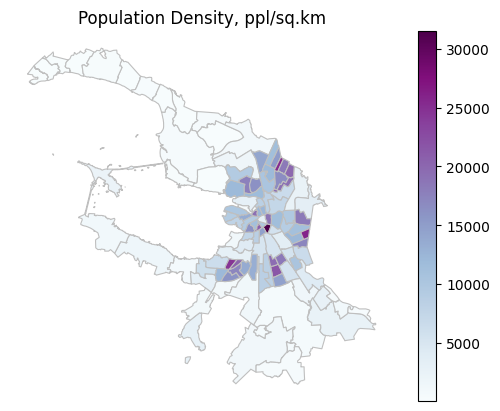

In [196]:
ax = spb_okrug_UTM.plot(column='pop_density', cmap='BuPu', linewidth=0.8, edgecolor='0.75', legend=True)

# добавляем название
ax.set_title('Population Density, ppl/sq.km')

# скрываем координатные оси
ax.axis('off')

plt.show()

В данном случай по дефолту метод plot использует непрерывную шкалу для отображения нашего показателя. Но чаще всего в работе нам нужно определять интервалы, на которые мы хотим разбить наши данные для визуализации.


Давайте посмотрим на распределение показателя pop_density


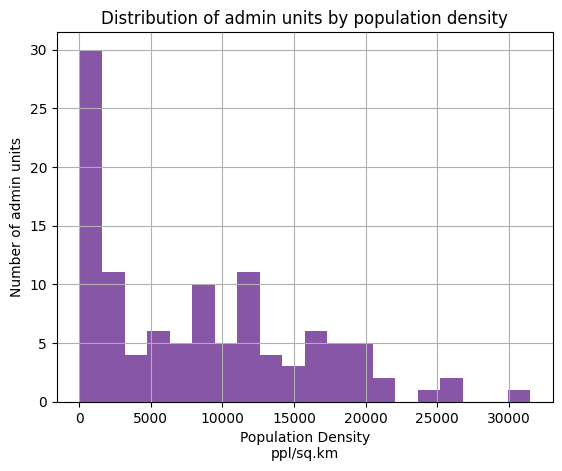

In [197]:
spb_okrug_UTM["pop_density"].hist(bins=20, color='#8856a7')
plt.xlabel("Population Density\nppl/sq.km")
plt.ylabel("Number of admin units")
plt.title("Distribution of admin units by population density")
plt.show()

Посмотреть на гистограмму распределения показателя перед выбором алгоритма классификации очень важно, так как это лучше поможет понять, как распределены данные, обнаружить выбросы, определить оптимальное количество классов


## Алгоритмы классификации


### Равные интервалы


Этот алгоритм делит данные на равные интервалы и подходит для данных с более-менее равномерным распределением


Разбиваем значения на 5 равных интервалов, для этого используем библиотеку mapclassify


In [198]:
# Определяем количество интервалов и схему классификации
k = 5
equalInterval = mc.EqualInterval(spb_okrug_UTM['pop_density'], k=k)

# записываем разделение на классы в атрибутивную таблицу
spb_okrug_UTM['equalInterval'] = equalInterval.yb

equalInterval

EqualInterval

      Interval         Count
----------------------------
[   28.15,  6322.18] |    51
( 6322.18, 12616.21] |    31
(12616.21, 18910.24] |    18
(18910.24, 25204.27] |     8
(25204.27, 31498.29] |     3

Строим гистрограмму распределения значений и цветом выделяем интервалы


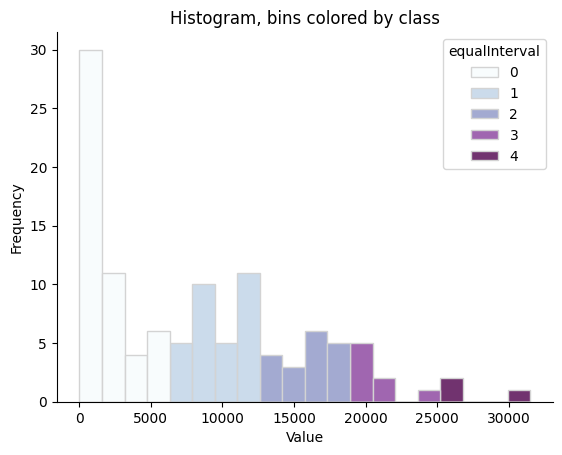

In [202]:
# Строим гистограмму
sns.histplot(data=spb_okrug_UTM, x='pop_density', hue='equalInterval', bins=20, alpha=0.8, palette='BuPu', edgecolor='lightgray')

# Убираем некрасивую границу графика
sns.despine()

# Добавляем подписи и заголовок
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram, bins colored by class')

# Показываем график
plt.show()

Создаем карту и спользуем метод "равных интервалов"


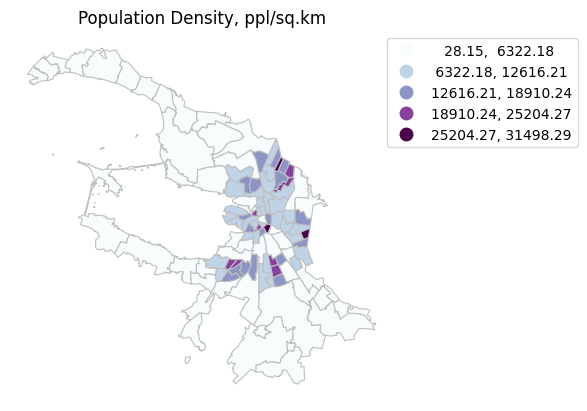

In [203]:
ax = spb_okrug_UTM.plot(column='pop_density', cmap='BuPu', linewidth=0.8, edgecolor='0.75', legend=True,  scheme="equalInterval", k = k )

# добавляем название
ax.set_title('Population Density, ppl/sq.km')

# скрываем координатные оси
ax.axis('off')

# Получаем объект легенды
leg = ax.get_legend()

# Перемещаем легенду за пределы графика справа
leg.set_bbox_to_anchor((1.5, 1))

plt.show()

#### \*Дополнение


Функция построения гистрограммы и создания карты


In [204]:
def plot_hist_with_intervals(data, column, scheme, k=None):
    classification_schemes = {
        "equalInterval": mc.EqualInterval,
        "naturalBreaks": mc.NaturalBreaks,
        "quantiles": mc.Quantiles,
        "stdMean": mc.StdMean,
    }
    
    classification_class = classification_schemes.get(scheme)

    if classification_class:

        #Создаем отображение карты и графика
        fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Проверяем, нужно ли учитывать параметр k для данной схемы
        if scheme in ["stdMean"]:
            classifier = classification_class(data[column])
            data[scheme] = classifier.yb
            
        else:
            classifier = classification_class(data[column], k=k)
            data[scheme] = classifier.yb
        
        # Строим гистограмму
        sns.histplot(data, x='pop_density', hue=scheme, bins=20, alpha=0.8, palette='BuPu', edgecolor='lightgray', ax=ax)

        # Убираем некрасивую границу графика
        sns.despine()

        #Создание карты 
        data.plot(column=column, cmap="BuPu", linewidth=0.8, edgecolor='0.75', legend=True, scheme=scheme, k=k, ax=ax2)
        
        # Добавляем название
        ax2.set_title("Population Density, ppl/sq.km")
        # Скрываем координатные оси
        ax2.axis('off')

        # Получаем объект легенды
        leg = ax2.get_legend()
        # Перемещаем легенду за пределы графика справа
        leg.set_bbox_to_anchor((1.5, 1))

        # Настройка пространства между графиками
        plt.tight_layout()
        # Отображение графиков
        plt.show()


    else:
        print(f"Схема классификации '{scheme}' не найдена.")


##### Отображаем гистограмму распределения показателя и карту рядом


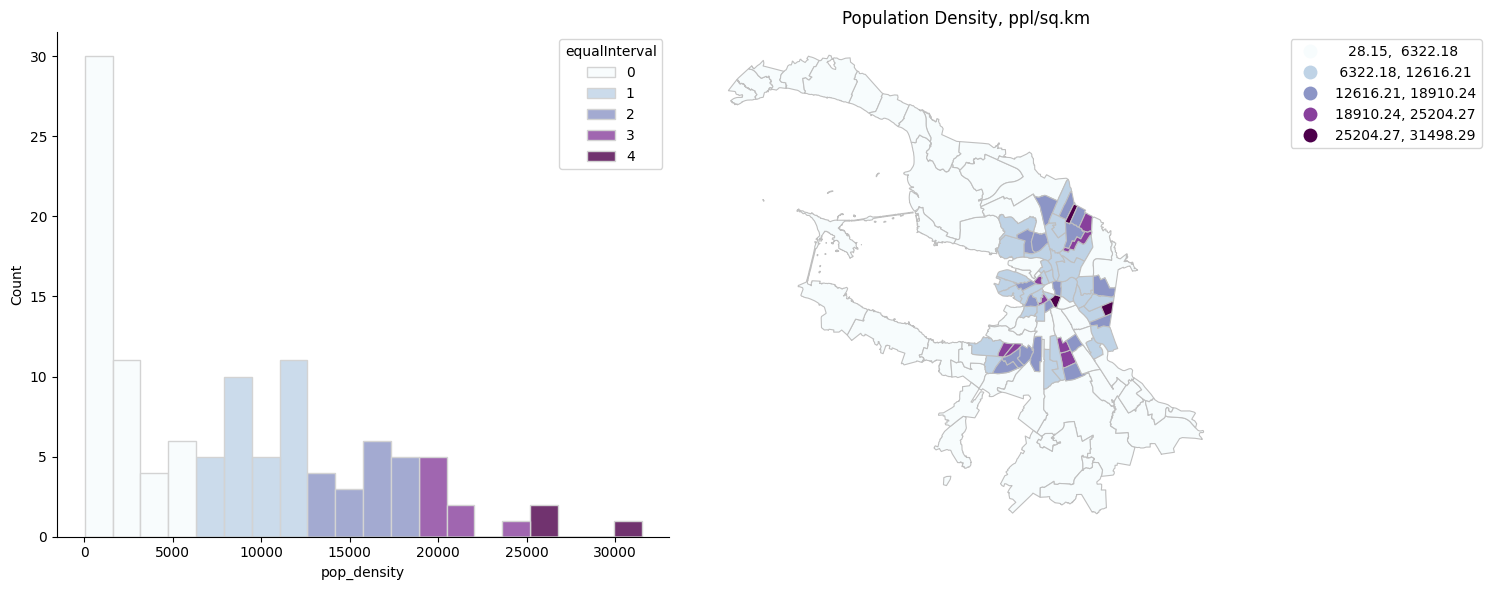

In [205]:
plot_hist_with_intervals(spb_okrug_UTM, 'pop_density', 'equalInterval', k=5)

### Естественные границы (по Дженксу)


Оптимизирует границы интервалов для минимизации различий внутри интервалов и максимизации различий между ними


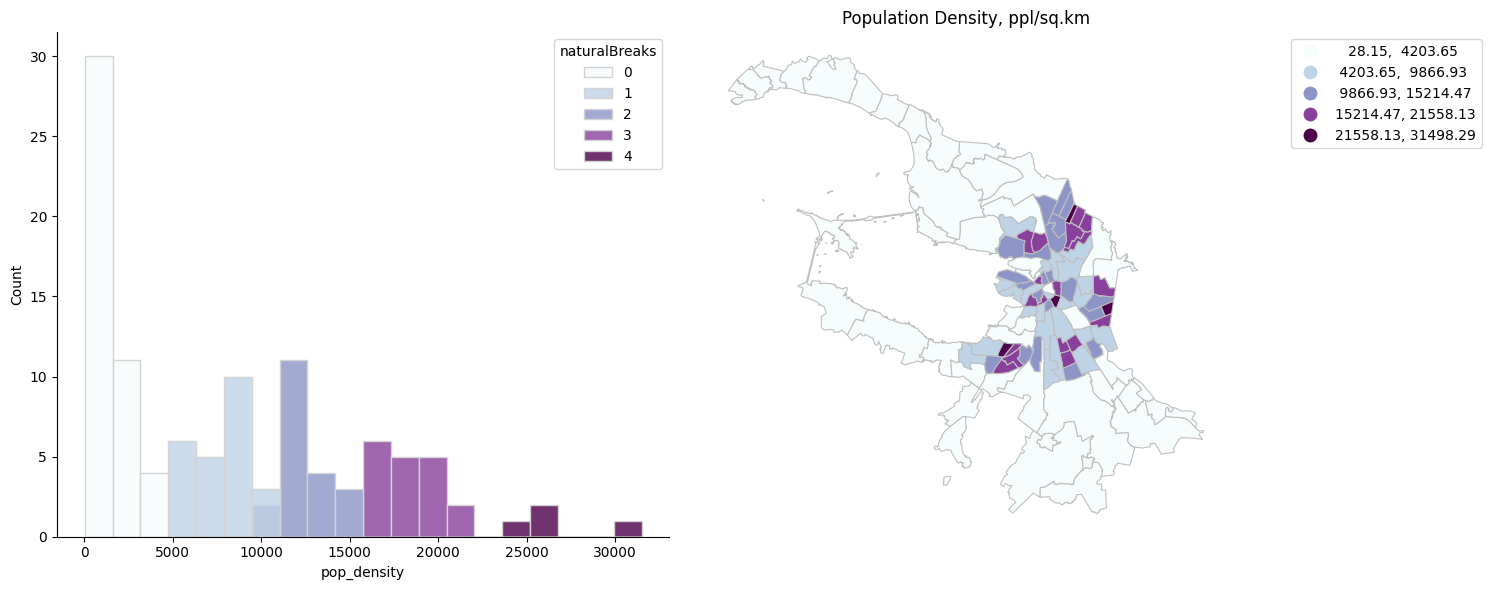

In [206]:
plot_hist_with_intervals(spb_okrug_UTM, 'pop_density', 'naturalBreaks', k=5)

### Квантиль


Этот алгоритм делит данные так, чтобы в каждом интервале было одинаковое количество значений. Этот метод классификации хорошо подходит для линейно распределенных данных.


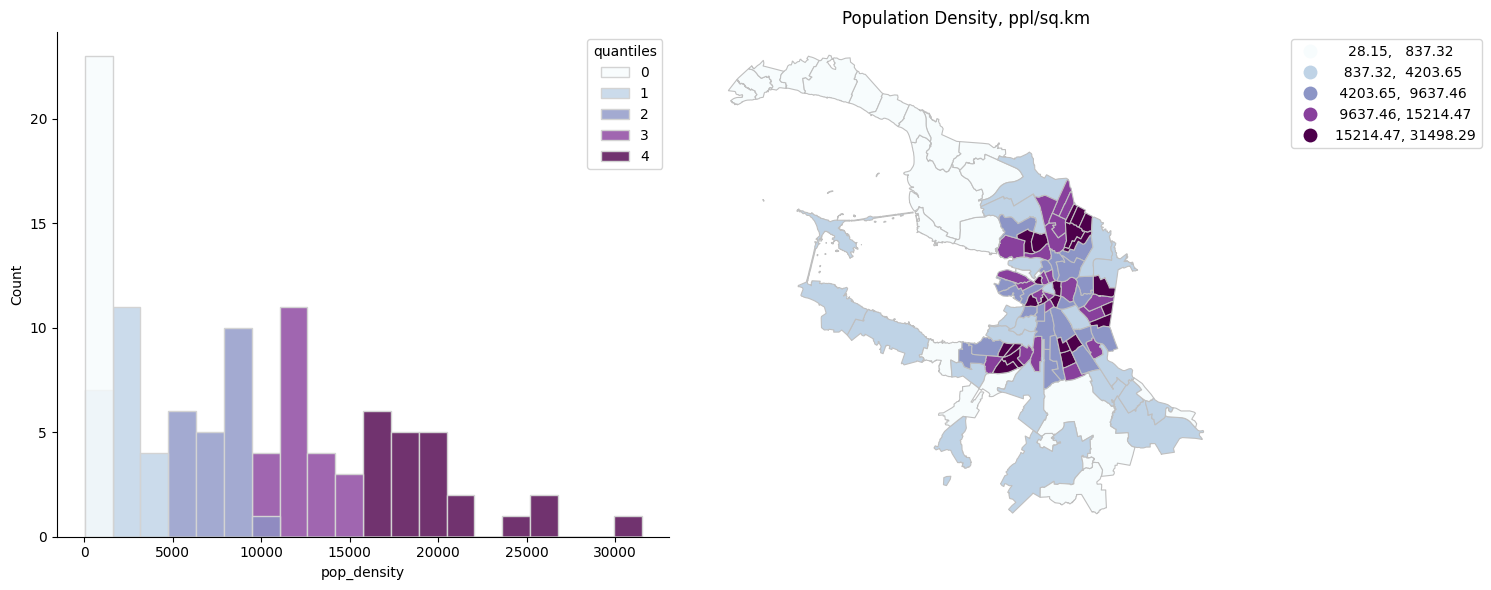

In [208]:
plot_hist_with_intervals(spb_okrug_UTM, 'pop_density', 'quantiles', k=5)

### Среднеквадратичное отклонение


Этот метод показывает, насколько значение атрибута объекта отличается от среднего значения.


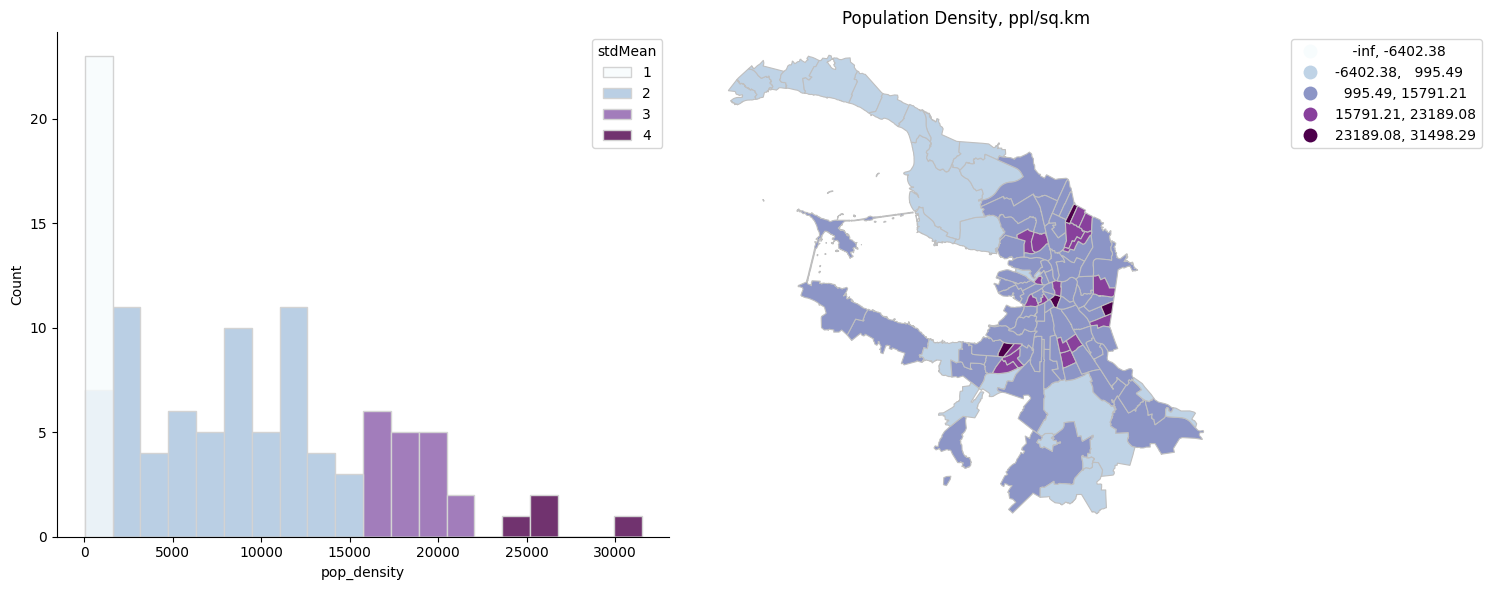

In [209]:
plot_hist_with_intervals(spb_okrug_UTM, 'pop_density', 'stdMean')

Посмотрим на интервалы


In [211]:
mc.StdMean(spb_okrug_UTM['pop_density'])

StdMean

      Interval         Count
----------------------------
(    -inf, -6402.38] |     0
(-6402.38,   995.49] |    23
(  995.49, 15791.21] |    66
(15791.21, 23189.08] |    18
(23189.08, 31498.29] |     4

Посчитаем среднеквадратичное отклонение и среднее значение для 'pop_density'


In [210]:
print("Среднеквадратическое отклонение: %i" % spb_okrug_UTM['pop_density'].std())
print("Среднее: %i" % spb_okrug_UTM['pop_density'].mean())

Среднеквадратическое отклонение: 7397
Среднее: 8393


### Пользовательские интервалы


Можно самостоятельно создать интервалы, которые лучше всего подходят для ваших данных. Чаще всего пользовательские интервалы основаны на одном из статистических алгоритмов классификаций

Давайте создадим собственные интервалы на основе "Естественных границ (по Дженксу)"


In [212]:
#Смотрим на интервалы 
naturalBreaks = mc.NaturalBreaks(spb_okrug_UTM['pop_density'], k=5)

naturalBreaks

NaturalBreaks

      Interval         Count
----------------------------
[   28.15,  4203.65] |    45
( 4203.65,  9866.93] |    23
( 9866.93, 15214.47] |    21
(15214.47, 21558.13] |    18
(21558.13, 31498.29] |     4

Определяем интервалы, близкие к значениям, получившимся при использовании метода "Естественные границы по Дженску"


In [213]:
bins = [4000, 10000, 15000, 22000, 32000]

# Классификация данных с использованием пользовательских классов
userDefined = mc.UserDefined(spb_okrug_UTM['pop_density'], bins)

# записываем разделение на классы в атрибутивную таблицу
spb_okrug_UTM['userDefined'] = userDefined.yb

userDefined

UserDefined

      Interval         Count
----------------------------
[   28.15,  4000.00] |    43
( 4000.00, 10000.00] |    25
(10000.00, 15000.00] |    20
(15000.00, 22000.00] |    19
(22000.00, 32000.00] |     4

Создаем карту с использованием выделенных интервалов


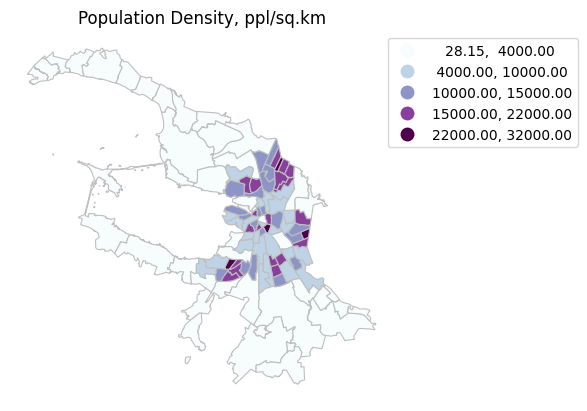

In [214]:
ax = spb_okrug_UTM.plot(column='pop_density', cmap='BuPu', linewidth=0.8, edgecolor='0.75', legend=True,  scheme='userDefined', classification_kwds={'bins':bins}, k = 5)

# добавляем название
ax.set_title('Population Density, ppl/sq.km')

# скрываем координатные оси
ax.axis('off')

# Получаем объект легенды
leg = ax.get_legend()

# Перемещаем легенду за пределы графика справа
leg.set_bbox_to_anchor((1.5, 1))

plt.show()

### Сравнение алгоритмов классификации


In [215]:
spb_okrug_UTM.head()

,NAME,Popul,geometry,area,pop_density,equalInterval,naturalBreaks,quantiles,stdMean,userDefined
0,округ Пискарёвка,61706.0,"MULTIPOLYGON (((352703.954 6653672.464, 353647...",9.292112e+06,6640.686076,1,1,2,2,1
1,Смолячково,742.0,"MULTIPOLYGON (((302068.083 6677873.169, 303389...",7.933135e+06,93.531751,0,0,0,1,0
2,Молодёжное,1685.0,"MULTIPOLYGON (((303389.678 6679568.341, 303601...",1.238612e+07,136.039328,0,0,0,1,0
3,Серово,272.0,"MULTIPOLYGON (((305157.564 6681218.991, 305563...",9.662041e+06,28.151402,0,0,0,1,0
4,Кронштадт,44374.0,"MULTIPOLYGON (((312486.108 6659698.584, 312488...",2.002856e+07,2215.536304,0,0,1,2,0


Сделаем сводный график - посмотрим, в какие интервалы попали районы при использовании разных методов классификации


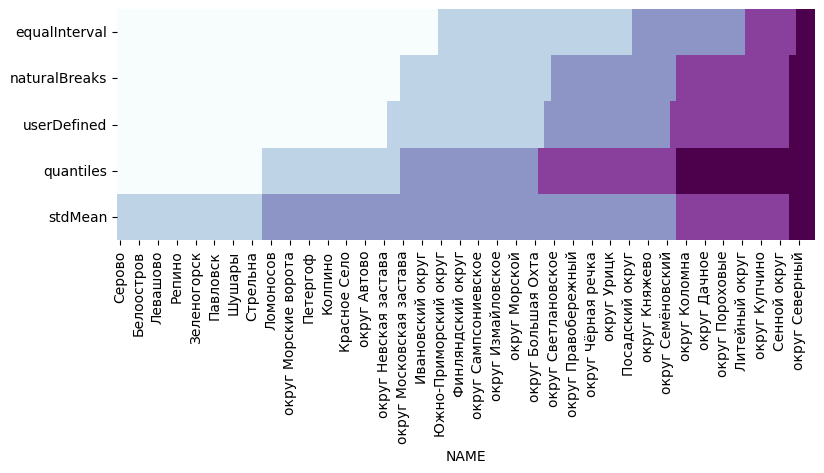

In [216]:
# Список схем классификации и соответствующих названий столбцов
schemes = ["equalInterval", "naturalBreaks", "userDefined", "quantiles", "stdMean", ]

#Построение графика
f, ax = plt.subplots(1, figsize=(9, 3))
sns.heatmap(
    spb_okrug_UTM.set_index("NAME")
    .sort_values("pop_density")[
        schemes
    ]
    .T,
    cmap="BuPu",
    cbar=False,
    ax=ax,
)
ax.set_xlabel("NAME")
plt.show()

## Итоги


В этом разделе мы познакомились с основными методами классификации значений для определения интервалов и убедились, что одни и те же данные можно визуализировать разными способами и от этого очень сильно будет зависеть итоговый результат


## Видео раздела


<iframe width="560" height="315" src="https://www.youtube.com/embed/lyGVDAd9rM8?si=nmUex27GyVGST__I" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>
